### Import libaries

In [0]:
import pandas as pd
import numpy as np 
import seaborn as sns 
%matplotlib inline
import matplotlib.pyplot as plt
import scipy.stats as ss

### Import data

In [0]:
# Read from url - Take time to run
url = "http://stat-computing.org/dataexpo/2009/2008.csv.bz2"
df = pd.read_csv(url, compression='bz2')

In [0]:
# Reduce rows
df = df.sample(frac=0.20)

In [1]:
df.head()

NameError: ignored

Variable descriptions: http://stat-computing.org/dataexpo/2009/the-data.html

Reference: https://www.kaggle.com/fabiendaniel/predicting-flight-delays-tutorial

### Data pre-processing

In [6]:
df.count()

Year                 2453405
Month                2453405
DayofMonth           2453405
DayOfWeek            2453405
DepTime              2405777
CRSDepTime           2453405
ArrTime              2400316
CRSArrTime           2453405
UniqueCarrier        2453405
FlightNum            2453405
TailNum              2424183
ActualElapsedTime    2399244
CRSElapsedTime       2453091
AirTime              2399244
ArrDelay             2399244
DepDelay             2405777
Origin               2453405
Dest                 2453405
Distance             2453405
TaxiIn               2400316
TaxiOut              2405476
Cancelled            2453405
CancellationCode       48067
Diverted             2453405
CarrierDelay          534081
WeatherDelay          534081
NASDelay              534081
SecurityDelay         534081
LateAircraftDelay     534081
dtype: int64

In [7]:
#Create Date column
#df['Date'] = pd.to_datetime(df[['Year', 'Month', 'DayofMonth']])

# Drop columns
# Year: The dataset only contains data in 2008
# Cancelled + CancellationCode + Diverted: Cancelled flight does not have delay label.
df.drop(['Year', 'Cancelled', 'CancellationCode', 'Diverted'], axis=1, inplace=True)
# Delay details: Only 20% rows have these features.
df.drop(['CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay'], axis=1, inplace=True)
# Time: Only keep CRSArrTime, CRSElapsedTime
df.drop(['DepTime', 'ArrTime', 'CRSDepTime', 'ActualElapsedTime'], axis=1, inplace=True)
# Airport: Only keep the Dest Airport
df.drop(['Origin'], axis=1, inplace=True)
# Carrier: Drop FlightNum and TailNum
df.drop(['FlightNum', 'TailNum'], axis=1, inplace=True)

df.dropna(inplace=True)
df.drop_duplicates(inplace=True)

df.count()

Month             2399243
DayofMonth        2399243
DayOfWeek         2399243
CRSArrTime        2399243
UniqueCarrier     2399243
CRSElapsedTime    2399243
AirTime           2399243
ArrDelay          2399243
DepDelay          2399243
Dest              2399243
Distance          2399243
TaxiIn            2399243
TaxiOut           2399243
dtype: int64

In [0]:
# Convert CRSArrTime to Parts of the Day
conditions = [
    (df['CRSArrTime'] >= 500) & (df['CRSArrTime'] < 1201),
    (df['CRSArrTime'] >= 1201) & (df['CRSArrTime'] < 1701),
    (df['CRSArrTime'] >= 1701) & (df['CRSArrTime'] < 2101)]
choices = [1, 2, 3]
df['PotD'] = np.select(conditions, choices, default=4)

# Morning, Afternoon, Evening, Night

In [0]:
# Convert ArrDelay to Delay
# A flight only counts as late if it is more than 30 minutes late.
conditions = [
    (df['ArrDelay'] > 30)]
choices = [1]
df['Delay'] = np.select(conditions, choices, default=0)
df.drop(['CRSArrTime'], axis=1, inplace=True)

In [10]:
df.dtypes

Month               int64
DayofMonth          int64
DayOfWeek           int64
UniqueCarrier      object
CRSElapsedTime    float64
AirTime           float64
ArrDelay          float64
DepDelay          float64
Dest               object
Distance            int64
TaxiIn            float64
TaxiOut           float64
PotD                int64
Delay               int64
dtype: object

In [11]:
df.head()

,Month,DayofMonth,DayOfWeek,UniqueCarrier,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Dest,Distance,TaxiIn,TaxiOut,PotD,Delay
2440958,5,18,7,WN,115.0,91.0,-6.0,4.0,HOU,687,5.0,9.0,4,0
2257375,4,2,3,9E,73.0,36.0,0.0,8.0,DTW,157,7.0,22.0,1,0
685927,2,27,3,WN,180.0,155.0,-14.0,-1.0,STL,1372,4.0,8.0,4,0
6822223,12,19,5,MQ,165.0,156.0,9.0,-15.0,DFW,812,11.0,22.0,2,0
221794,1,31,4,UA,279.0,240.0,188.0,200.0,LAX,1745,7.0,20.0,4,1


### Data analysis

In [12]:
#Check basic stats
df.describe()

,Month,DayofMonth,DayOfWeek,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Distance,TaxiIn,TaxiOut,PotD,Delay
count,2.399243e+06,2.399243e+06,2.399243e+06,2.399243e+06,2.399243e+06,2.399243e+06,2.399243e+06,2.399243e+06,2.399243e+06,2.399243e+06,2.399243e+06,2.399243e+06
mean,6.387044e+00,1.574196e+01,3.925990e+00,1.290456e+02,1.039958e+02,8.171378e+00,9.912274e+00,7.285296e+02,6.859276e+00,1.644969e+01,2.243208e+00,1.315673e-01
std,3.399372e+00,8.800274e+00,1.988795e+00,6.949167e+01,6.739851e+01,3.840900e+01,3.510874e+01,5.630271e+02,4.929071e+00,1.130719e+01,1.019246e+00,3.380198e-01
min,1.000000e+00,1.000000e+00,1.000000e+00,-1.410000e+02,0.000000e+00,-1.090000e+02,-9.200000e+01,1.100000e+01,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00
25%,3.000000e+00,8.000000e+00,2.000000e+00,8.000000e+01,5.600000e+01,-1.000000e+01,-4.000000e+00,3.280000e+02,4.000000e+00,1.000000e+01,1.000000e+00,0.000000e+00
50%,6.000000e+00,1.600000e+01,4.000000e+00,1.110000e+02,8.600000e+01,-2.000000e+00,-1.000000e+00,5.810000e+02,6.000000e+00,1.400000e+01,2.000000e+00,0.000000e+00
75%,9.000000e+00,2.300000e+01,6.000000e+00,1.590000e+02,1.320000e+02,1.200000e+01,8.000000e+00,9.540000e+02,8.000000e+00,1.900000e+01,3.000000e+00,0.000000e+00
max,1.200000e+01,3.100000e+01,7.000000e+00,6.600000e+02,1.154000e+03,2.461000e+03,2.457000e+03,4.962000e+03,3.080000e+02,4.290000e+02,4.000000e+00,1.000000e+00


In [13]:
#Check correlation
df.corr()

,Month,DayofMonth,DayOfWeek,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Distance,TaxiIn,TaxiOut,PotD,Delay
Month,1.000000,-0.000450,-0.004948,-0.005807,-0.011894,-0.041830,-0.030362,-0.005105,0.006708,-0.015538,-0.005771,-0.034726
DayofMonth,-0.000450,1.000000,0.003893,0.000880,0.000525,0.001300,0.003142,0.000709,-0.003289,-0.001622,-0.001197,-0.000783
DayOfWeek,-0.004948,0.003893,1.000000,0.015265,0.014070,0.009990,0.015122,0.016992,0.009713,-0.007301,0.002780,0.010264
CRSElapsedTime,-0.005807,0.000880,0.015265,1.000000,0.988146,0.011745,0.034813,0.983156,0.104123,0.142185,0.090617,0.030807
AirTime,-0.011894,0.000525,0.014070,0.988146,1.000000,0.033874,0.026838,0.982853,0.085022,0.106939,0.077488,0.040783
ArrDelay,-0.041830,0.001300,0.009990,0.011745,0.033874,1.000000,0.931061,0.005436,0.122762,0.322684,0.114939,0.740611
DepDelay,-0.030362,0.003142,0.015122,0.034813,0.026838,0.931061,1.000000,0.025301,0.023647,0.101368,0.140852,0.687138
Distance,-0.005105,0.000709,0.016992,0.983156,0.982853,0.005436,0.025301,1.000000,0.077024,0.090131,0.090433,0.018377
TaxiIn,0.006708,-0.003289,0.009713,0.104123,0.085022,0.122762,0.023647,0.077024,1.000000,0.040789,-0.020055,0.087961
TaxiOut,-0.015538,-0.001622,-0.007301,0.142185,0.106939,0.322684,0.101368,0.090131,0.040789,1.000000,0.056865,0.290095


In [14]:
# Groupby carrier
df.groupby(['UniqueCarrier']).mean()

,Month,DayofMonth,DayOfWeek,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Distance,TaxiIn,TaxiOut,PotD,Delay
UniqueCarrier,,,,,,,,,,,,
9E,6.506692,15.760454,3.917964,100.328449,71.125774,4.055245,6.711277,450.797112,8.503107,18.043535,2.189369,0.106467
AA,6.438789,15.784132,3.963804,167.399184,141.708493,12.701157,13.274399,1055.103486,8.248655,16.868794,2.327101,0.172777
AQ,1.496642,15.327612,3.945522,75.055224,61.712313,-2.859701,-1.364179,422.502612,3.858582,7.991418,2.131716,0.022761
AS,6.396145,15.713772,3.942383,155.414087,132.160824,4.608360,6.546180,962.991744,5.796137,15.519286,2.343748,0.105702
B6,6.402591,15.823590,3.992270,179.861173,150.318407,11.097705,12.569747,1100.393810,6.260418,21.810307,2.348734,0.168133
CO,6.320386,15.735293,3.912752,186.357882,155.773979,11.023467,13.178697,1153.945569,7.965000,20.463674,2.309155,0.152988
DL,6.509178,15.707156,3.914831,156.373782,126.980622,7.821657,7.910928,925.380668,8.674618,20.629271,2.245581,0.117458
EV,6.490535,15.676562,3.929483,95.465908,69.725660,10.268207,11.956099,442.746173,7.336974,16.715382,2.102349,0.149270
F9,6.441441,15.794284,3.954153,143.478357,121.798779,5.822388,5.656803,880.963263,7.376213,14.468949,2.334891,0.091009


In [15]:
# Groupby destination airport
df.groupby(['Dest']).mean()

,Month,DayofMonth,DayOfWeek,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Distance,TaxiIn,TaxiOut,PotD,Delay
Dest,,,,,,,,,,,,
ABE,6.508108,15.721922,3.801802,100.685285,73.906907,8.766366,10.882883,537.334535,4.473273,20.188589,2.777177,0.144144
ABI,6.418919,15.497748,3.959459,53.380631,33.755631,8.880631,9.631757,158.000000,3.596847,15.277027,2.682432,0.129505
ABQ,6.380814,15.878115,3.920681,114.185908,92.224183,6.187846,9.369255,652.604305,5.316653,13.463663,2.284122,0.109150
ABY,6.052632,14.992105,3.913158,54.244737,27.844737,11.868421,11.644737,146.000000,3.581579,23.042105,2.589474,0.165789
ACK,7.229167,16.513889,4.083333,85.930556,46.687500,21.534722,16.569444,207.840278,5.958333,38.250000,2.034722,0.277778
ACT,6.058224,15.807860,3.871907,44.905386,23.579330,6.132460,7.506550,89.000000,4.902475,15.049491,2.203785,0.104803
ACV,6.561347,15.789094,3.942261,76.711307,57.049719,12.852446,12.163593,264.020048,4.447474,15.902967,2.460305,0.158781
ACY,2.692308,17.461538,3.871795,113.410256,88.743590,17.410256,14.512821,678.000000,3.333333,24.230769,2.820513,0.076923
ADK,7.033333,14.866667,5.100000,188.833333,172.300000,8.700000,6.800000,1192.000000,4.333333,14.100000,2.666667,0.100000


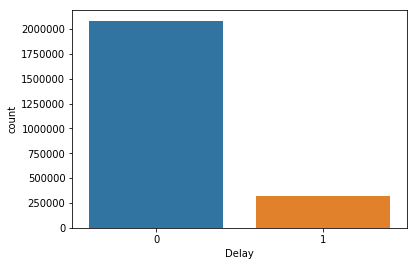

In [16]:
# Bias check
sns.countplot(x="Delay", data=df)

In [0]:
# Check Correlation
def cramers_corrected_stat(x, y):

    """ calculate Cramers V statistic for categorial-categorial association.
        uses correction from Bergsma and Wicher, 
        Journal of the Korean Statistical Society 42 (2013): 323-328
    """
    result=-1
    if len(x.value_counts())==1 :
        print("First variable is constant")
    elif len(y.value_counts())==1:
        print("Second variable is constant")
    else:   
        conf_matrix=pd.crosstab(x, y)

        if conf_matrix.shape[0]==2:
            correct=False
        else:
            correct=True

        chi2 = ss.chi2_contingency(conf_matrix, correction=correct)[0]

        n = sum(conf_matrix.sum())
        phi2 = chi2/n
        r,k = conf_matrix.shape
        phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))    
        rcorr = r - ((r-1)**2)/(n-1)
        kcorr = k - ((k-1)**2)/(n-1)
        result=np.sqrt(phi2corr / min( (kcorr-1), (rcorr-1)))
    return round(result,6)

#### Month

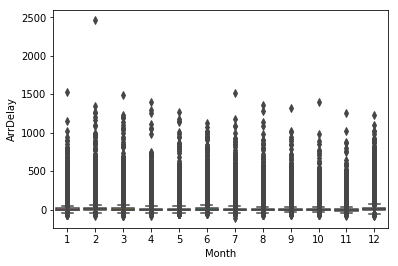

In [18]:
sns.boxplot(x='Month', y='ArrDelay', data=df) #x is feature, y is target

In [19]:
cramers_corrected_stat(df['Delay'], df['Month'])

0.11831

#### DayofMonth

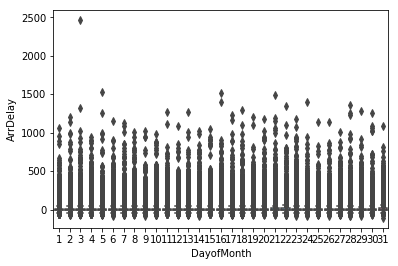

In [20]:
sns.boxplot(x='DayofMonth', y='ArrDelay', data=df) #x is feature, y is target

In [21]:
cramers_corrected_stat(df['Delay'], df['DayofMonth'])

0.035782

#### Weekend

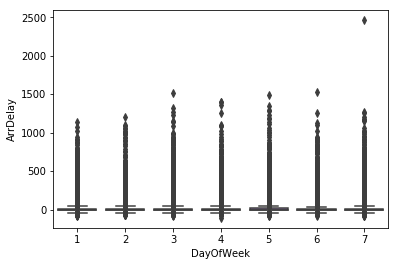

In [22]:
sns.boxplot(x='DayOfWeek', y='ArrDelay', data=df) #x is feature, y is target

In [23]:
cramers_corrected_stat(df['Delay'], df['DayOfWeek'])

0.036463

#### Parts of the Day

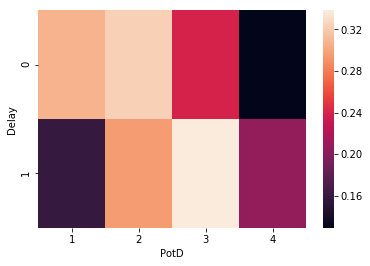

In [24]:
sns.heatmap(pd.crosstab(df['Delay'], df['PotD'], normalize='index'))

In [25]:
cramers_corrected_stat(df['Delay'], df['PotD'])

0.135332

### Encoding

In [0]:
# Apply One-hot encoding to Dest column

df = pd.concat([df, pd.get_dummies(df['Dest'], prefix='Dest',dummy_na=True)],axis=1).drop(['Dest'],axis=1)

In [0]:
# Apply One-hot encoding to UniqueCarrier column

df = pd.concat([df, pd.get_dummies(df['UniqueCarrier'], prefix='UniqueCarrier',dummy_na=True)],axis=1).drop(['UniqueCarrier'],axis=1)

In [28]:
df.head()

,Month,DayofMonth,DayOfWeek,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Distance,TaxiIn,TaxiOut,PotD,Delay,Dest_ABE,Dest_ABI,Dest_ABQ,Dest_ABY,Dest_ACK,Dest_ACT,Dest_ACV,Dest_ACY,Dest_ADK,Dest_ADQ,Dest_AEX,Dest_AGS,Dest_AKN,Dest_ALB,Dest_ALO,Dest_AMA,Dest_ANC,Dest_ASE,Dest_ATL,Dest_ATW,Dest_AUS,Dest_AVL,Dest_AVP,Dest_AZO,Dest_BDL,Dest_BET,Dest_BFL,Dest_BGM,...,Dest_TPA,Dest_TRI,Dest_TUL,Dest_TUP,Dest_TUS,Dest_TVC,Dest_TWF,Dest_TXK,Dest_TYR,Dest_TYS,Dest_VLD,Dest_VPS,Dest_WRG,Dest_WYS,Dest_XNA,Dest_YAK,Dest_YKM,Dest_YUM,Dest_nan,UniqueCarrier_9E,UniqueCarrier_AA,UniqueCarrier_AQ,UniqueCarrier_AS,UniqueCarrier_B6,UniqueCarrier_CO,UniqueCarrier_DL,UniqueCarrier_EV,UniqueCarrier_F9,UniqueCarrier_FL,UniqueCarrier_HA,UniqueCarrier_MQ,UniqueCarrier_NW,UniqueCarrier_OH,UniqueCarrier_OO,UniqueCarrier_UA,UniqueCarrier_US,UniqueCarrier_WN,UniqueCarrier_XE,UniqueCarrier_YV,UniqueCarrier_nan
2440958,5,18,7,115.0,91.0,-6.0,4.0,687,5.0,9.0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2257375,4,2,3,73.0,36.0,0.0,8.0,157,7.0,22.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
685927,2,27,3,180.0,155.0,-14.0,-1.0,1372,4.0,8.0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
6822223,12,19,5,165.0,156.0,9.0,-15.0,812,11.0,22.0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
221794,1,31,4,279.0,240.0,188.0,200.0,1745,7.0,20.0,4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0


### Model evaluation

In [0]:
#features = df.drop(['Delay'], axis=1)
# Why?
# Airline:
# Dest Airport + CRSArrTime: 
# Departure features:


X_data = df.drop(['Delay', 'ArrDelay'], axis=1)
y_data = df['Delay']

# Holdout
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, random_state=0)

In [30]:
X_train.head()

,Month,DayofMonth,DayOfWeek,CRSElapsedTime,AirTime,DepDelay,Distance,TaxiIn,TaxiOut,PotD,Dest_ABE,Dest_ABI,Dest_ABQ,Dest_ABY,Dest_ACK,Dest_ACT,Dest_ACV,Dest_ACY,Dest_ADK,Dest_ADQ,Dest_AEX,Dest_AGS,Dest_AKN,Dest_ALB,Dest_ALO,Dest_AMA,Dest_ANC,Dest_ASE,Dest_ATL,Dest_ATW,Dest_AUS,Dest_AVL,Dest_AVP,Dest_AZO,Dest_BDL,Dest_BET,Dest_BFL,Dest_BGM,Dest_BGR,Dest_BHM,...,Dest_TPA,Dest_TRI,Dest_TUL,Dest_TUP,Dest_TUS,Dest_TVC,Dest_TWF,Dest_TXK,Dest_TYR,Dest_TYS,Dest_VLD,Dest_VPS,Dest_WRG,Dest_WYS,Dest_XNA,Dest_YAK,Dest_YKM,Dest_YUM,Dest_nan,UniqueCarrier_9E,UniqueCarrier_AA,UniqueCarrier_AQ,UniqueCarrier_AS,UniqueCarrier_B6,UniqueCarrier_CO,UniqueCarrier_DL,UniqueCarrier_EV,UniqueCarrier_F9,UniqueCarrier_FL,UniqueCarrier_HA,UniqueCarrier_MQ,UniqueCarrier_NW,UniqueCarrier_OH,UniqueCarrier_OO,UniqueCarrier_UA,UniqueCarrier_US,UniqueCarrier_WN,UniqueCarrier_XE,UniqueCarrier_YV,UniqueCarrier_nan
2612907,5,16,5,334.0,314.0,-4.0,2306,6.0,14.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
5858591,10,4,6,140.0,99.0,-6.0,732,11.0,10.0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1865144,4,25,5,160.0,145.0,98.0,972,6.0,58.0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
4247619,8,7,4,60.0,43.0,-5.0,239,5.0,9.0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
294390,1,31,4,289.0,253.0,7.0,1774,4.0,25.0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0


#### Naive Bayes

In [0]:
from sklearn.naive_bayes import GaussianNB
model = GaussianNB()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [0]:
# Metrics
# https://medium.com/thalus-ai/performance-metrics-for-classification-problems-in-machine-learning-part-i-b085d432082b
# Confusion Matrix
from sklearn.metrics import confusion_matrix

print(confusion_matrix(y_test, y_pred))

# Report
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

[[391506  25147]
 [  2036  61157]]
              precision    recall  f1-score   support

           0       0.99      0.94      0.97    416653
           1       0.71      0.97      0.82     63193

    accuracy                           0.94    479846
   macro avg       0.85      0.95      0.89    479846
weighted avg       0.96      0.94      0.95    479846



#### Logistic Regression

#### Gradient Boosting

#### Random Forest

# TODO

1. Edit threshhold / class weight
2. PCA: Dimension reducing
3. RFE: Features selection
4. GridsearchCV for tuning
- Tuning with 3 values
- Goal: Precison ~ Recall
5. Compare performances among models